In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
from copy import deepcopy

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "LeNet" # valid values: LeNet, ResNet

BATCH_SIZE = 128


Using device: cuda


In [ ]:
'''
def create_fractional_list_for(n):
    if n == 0:
        return [] # Avoid division by zero
    
    result = []
    # Iterate from 0 up to and including n
    for i in range(n + 1):
        result.append(i / n)
    return result
n_value = 6
my_list = create_fractional_list_for(n_value)
print(f"List for n={n_value}: {my_list}")
'''

In [30]:
# Load MNIST data
def load_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, 
                                   download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, 
                                  download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=2)
    
    return train_loader, test_loader

In [31]:
# Load data
print("\n..... Loading MNIST dataset...")
train_loader, test_loader = load_mnist(BATCH_SIZE)
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


..... Loading MNIST dataset...
Training samples: 60000
Test samples: 10000


In [32]:
def evaluate_model(model, test_loader, criterion, mode=None,c=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data, mode=mode,c=c)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [33]:
def load_model(model_path, model_type='LeNet', device=None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Loading {model_type} model from {model_path}...")
    
    # Initialize the model architecture
    if model_type == 'LeNet':
        model = LeNet(num_classes=10)
    elif model_type == 'ResNet':
        model = ResNet(num_classes=10)
    else:
        raise ValueError(f"Unknown model type: {model_type}. Use 'LeNet' or 'ResNet'")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    
    print(f"✓ Model loaded successfully!")
    print(f"  - Trained for {checkpoint['epoch']} epochs")
    print(f"  - Test (Baseline) Accuracy: {checkpoint['test_acc']:.2f}%")
    print(f"  - Test Loss: {checkpoint['test_loss']:.4f}")
    
    # checkpoint: Dictionary containing training history and metrics
    return model, checkpoint

In [34]:
def load_test_model(model_path, model_type='LeNet', mode=None,c=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the model
    model, checkpoint = load_model(model_path, model_type, device)
    
    # Load test data
    #_, test_loader = load_mnist(batch_size=128)
    
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    ver_loss, ver_acc = evaluate_model(model, test_loader, criterion, mode,c)
    
    print(f"\nVerification Test:")
    print(f"  Verification Loss: {ver_loss:.4f}")
    print(f"  Verification Accuracy: {ver_acc:.2f}%")
    
    # Access training history if needed
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"\nTraining History Available:")
        print(f"  - Number of epochs: {len(history['train_loss'])}")
        print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
        print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    
    return model, checkpoint

In [ ]:
def verify_model(model, mode=None,c=None, verbose=False):
  
    # Evaluate the loaded model
    criterion = nn.CrossEntropyLoss()
    ver_loss, ver_acc = evaluate_model(model, test_loader, criterion, mode,c)
    
    print(f"\nVerification Test:")
    print(f"  Verification Loss: {ver_loss:.4f}")
    print(f"  Verification Accuracy: {ver_acc:.2f}%")
    
    '''
    # Access training history if needed
    if verbose:
        if 'history' in checkpoint:
            history = checkpoint['history']
            print(f"\nTraining History Available:")
            print(f"  - Number of epochs: {len(history['train_loss'])}")
            print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
            print(f"  - Best test accuracy: {max(history['test_acc']):.2f}%")
    '''
    
    return ver_acc, ver_loss

In [ ]:
# Load & Verify model
'''
model_filename = f'{model_name}_mnist.pth'
print("\n------ Loading & Verifying model .......\n")
lenet_model, lenet_checkpoint = load_test_model(model_filename, model_name, mode="compress",c=(0.5,0.3,0.1,0.1))
'''

In [ ]:
# Load the model
model_filename = f'{model_name}_mnist.pth'
print("\n------ Loading model ..... \n")
model, checkpoint = load_model(model_filename, model_name, device)

In [ ]:
# Verify the model
'''
print("\n------ Verifying model ..... \n")
ver_acc, ver_loss = verify_model(model, mode="compress",c=(0.5,0.3,0.1,0.1))
'''

In [35]:
def line_box_intersection(line_start, line_end, box_min, box_max):
    """
    Finds the intersection points of a line segment and an axis-aligned bounding box (AABB).

    Args:
        line_start (np.array): The start point of the line (e.g., np.array([x, y, z])).
        line_end (np.array): The end point of the line (e.g., np.array([x, y, z])).
        box_min (np.array): The minimum corner of the box (e.g., np.array([xmin, ymin, zmin])).
        box_max (np.array): The maximum corner of the box (e.g., np.array([xmax, ymax, zmax])).

    Returns:
        list: A list of intersection points (up to two points).
    """
    #thanks Google's AI
    line_dir = line_end - line_start
    # Pre-calculate inverse direction components to replace division with multiplication (faster)
    # Handle cases where a component is zero
    inv_dir = np.array([1/line_dir[i] if line_dir[i] != 0 else np.inf for i in range(len(line_dir))])

    t_min = -np.inf
    t_max = np.inf
    
    intersection_points = []

    for i in range(len(line_start)): # Iterate over x, y, z dimensions
        t1 = (box_min[i] - line_start[i]) * inv_dir[i]
        t2 = (box_max[i] - line_start[i]) * inv_dir[i]

        # Ensure t1 is the smaller intersection parameter
        if t1 > t2:
            t1, t2 = t2, t1

        # Update the overall t_min and t_max for the intersection interval
        t_min = max(t_min, t1)
        t_max = min(t_max, t2)

        # If t_min becomes greater than t_max, the line does not intersect the box
        if t_min > t_max:
            return []

    # The line intersects the box. The intersection occurs between t_min and t_max.
    # The actual points of entry and exit within the original line segment range [0, 1] are determined here.

    # Clamp t_min and t_max to the line segment range [0, 1] if you're working with a segment
    # If using an infinite line, skip this clamping step.
    t_start = max(0, t_min)
    t_end = min(1, t_max)

    if t_start <= t_end:
        # Calculate intersection points
        if t_start >= 0 and t_start <= 1:
            points = line_start + t_start * line_dir
            intersection_points.append(points)
        if t_end >= 0 and t_end <= 1 and t_end != t_start: # Avoid adding the same point twice
            points = line_start + t_end * line_dir
            intersection_points.append(points)
            
    return intersection_points

def split_line_nd(start_point, end_point, num_points):
    """
    Generates num_points equally spaced along a line segment between 
    start_point and end_point in N dimensions.

    Args:
        start_point (iterable): The starting point (e.g., [x1, y1, z1])
        end_point (iterable): The ending point (e.g., [x2, y2, z2])
        num_points (int): The total number of points to generate (must be >= 2).

    Returns:
        np.ndarray: An array of shape (num_points, N) containing the points.
    """
    #thanks Google's AI
    if num_points < 2:
        return np.array([start_point, end_point])

    # Convert to numpy arrays for easier calculation
    p1 = np.array(start_point)
    p2 = np.array(end_point)
    
    # Generate the interpolation factors (0 to 1)
    # The number of steps is num_points - 1
    t = np.linspace(0, 1, num_points)

    # Linear interpolation formula: P(t) = P1 + t * (P2 - P1)
    # The result will be an array of points
    points = p1 + t[:, np.newaxis] * (p2 - p1)
    
    return points

def getcpoints(x0,u,num_segments=5):
    x1=x0+u
    box_min = np.zeros_like(x0)
    box_max = np.ones_like(x0)
    start,end = line_box_intersection(x0, x1, box_min, box_max)
    #print(start,end)
    result_points = split_line_nd(start, end, num_segments)
    return(result_points)

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x, mode=None):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        if mode=="Test":
            print("ResidualBlock Forward Testing !!!!!!!!!")
        return out

In [37]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(16, 16, 2, stride=1)
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 64, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x, mode=None):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        if mode=="Test":
            print("ResNet Forward Testing !!!!!!!!!")
        return x

In [38]:
def compress(X,c=1):
    c=1-c
    if c==1:
        return X
    dout = X.shape[1]
    
    # Calculate L1 norm for each output channel
    if len(X.shape)==2:
        Xvalues = torch.abs(X)
    elif len(X.shape)==4:
        Xvalues = torch.sum(torch.abs(X), dim=(2, 3))

    #print(Xvalues.shape)
    
    # Calculate how many channels to prune
    k = int(dout * c)

    x, i = torch.topk(Xvalues, k, dim=1)
    mask = torch.zeros_like(Xvalues,dtype=torch.int)
    src = torch.ones_like(i,dtype=torch.int)
    mask.scatter_(1, i, src)
    #print(Xvalues,x,i)
    #print(mask)
    if len(X.shape)==2:
        return mask*X
    else:
        #print(mask.shape,X.shape)
        #print(mask)
        mask=mask.unsqueeze(2)
        mask=mask.unsqueeze(3)
        mask=mask.repeat((1,1,X.shape[2],X.shape[3]))
        return mask*X

In [39]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x, mode=None,pp=False,c=(0,0,0,0)):
        if c==None:
            c=(0,0,0,0)
        x = self.pool(self.relu(self.conv1(x)))
        #layer 1
        #print("hahahahahhahahahahhahahh!!!!!!!!!!!!!!!!")
        if pp:
            print("hahahahahhahahahahhahahh!!!!!!!!!@!!!!!!!")
            print(pp)
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[0])
            #print(x.shape)
        x = self.pool(self.relu(self.conv2(x)))
        #layer 2
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[1])
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        #layer 3
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[2])
        x = self.relu(self.fc2(x))
        #layer 4
        if pp:
            print(x.shape)
        if mode=="compress":
            x=compress(x,c[3])
        x = self.fc3(x)
        if mode=="Test":
            print("LeNet Forward Testing !!!!!!!!!")
        if pp:
            sys.exit()
        return x

In [44]:
'''
compressions = [[[0, 0, 0 ,0], [1, 0, 0, 0]],
                [[0, 0, 0 ,0], [1, 1, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0.5, 0.75, 1]],
                [[0, 0, 0 ,0], [0, 0.3, 1, 1]],
                ]

max_segments = 6
'''

In [45]:
def run_experiments(model, compressions, max_segments):

    results = {}
    compresion_id = 0
    for compression in compressions:
        print(f"\n-------- Analyzing {compression}:")
        
        line_start_2d = np.array(compression[0])
        line_dir = np.array(compression[1])
        cpoints = getcpoints(line_start_2d,line_dir,max_segments)
        print("\n ---- CPOINTS: -----\n")
        print(cpoints)
        print("-----------------------\n")
        
        accuracies = []
        for ci in cpoints:
            ver_acc, ver_loss = verify_model(model, mode="compress",c=ci.tolist())
            accuracies.append(ver_acc)
            print(f"\n------  C point {ci} : {ver_acc:.2f}%\n")
        
        results[compresion_id] = accuracies
        compresion_id = compresion_id + 1
    return results

In [54]:

compressions = [[[0, 0, 0 ,0], [1, 0, 0, 0]],
                [[0, 0, 0 ,0], [1, 1, 1, 1]],
                [[0, 0, 0 ,0], [0, 1, 1, 0]],
                [[0, 0, 0 ,0], [0.25, 0.5, 0.75, 1]],
                [[0, 0, 0 ,0], [0, 0.3, 1, 1]],
                ]
'''
compressions = [[[0, 0, 0 ,0], [1, 0, 0, 0]],

                ]
'''
max_segments = 8

In [55]:
results = run_experiments(model, compressions, max_segments)
results

/tmp/ipykernel_3549742/2629352356.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  t1 = (box_min[i] - line_start[i]) * inv_dir[i]



-------- Analyzing [[0, 0, 0, 0], [1, 0, 0, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.14285714 0.         0.         0.        ]
 [0.28571429 0.         0.         0.        ]
 [0.42857143 0.         0.         0.        ]
 [0.57142857 0.         0.         0.        ]
 [0.71428571 0.         0.         0.        ]
 [0.85714286 0.         0.         0.        ]
 [1.         0.         0.         0.        ]]
-----------------------



Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.85it/s]



Verification Test:
  Verification Loss: 0.0281
  Verification Accuracy: 99.07%

------  C point [0. 0. 0. 0.] : 99.07%



Evaluating: 100%|██████████| 79/79 [00:11<00:00,  6.86it/s]



Verification Test:
  Verification Loss: 0.1497
  Verification Accuracy: 95.11%

------  C point [0.14285714 0.         0.         0.        ] : 95.11%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.56it/s]



Verification Test:
  Verification Loss: 0.2720
  Verification Accuracy: 90.72%

------  C point [0.28571429 0.         0.         0.        ] : 90.72%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.42it/s]



Verification Test:
  Verification Loss: 0.5594
  Verification Accuracy: 80.63%

------  C point [0.42857143 0.         0.         0.        ] : 80.63%



Evaluating: 100%|██████████| 79/79 [00:12<00:00,  6.36it/s]



Verification Test:
  Verification Loss: 1.3924
  Verification Accuracy: 53.75%

------  C point [0.57142857 0.         0.         0.        ] : 53.75%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.90it/s]



Verification Test:
  Verification Loss: 2.5997
  Verification Accuracy: 31.93%

------  C point [0.71428571 0.         0.         0.        ] : 31.93%



Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.41it/s]



Verification Test:
  Verification Loss: 2.3153
  Verification Accuracy: 10.28%

------  C point [0.85714286 0.         0.         0.        ] : 10.28%



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.79it/s]



Verification Test:
  Verification Loss: 2.3153
  Verification Accuracy: 10.28%

------  C point [1. 0. 0. 0.] : 10.28%


-------- Analyzing [[0, 0, 0, 0], [1, 1, 1, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.14285714 0.14285714 0.14285714 0.14285714]
 [0.28571429 0.28571429 0.28571429 0.28571429]
 [0.42857143 0.42857143 0.42857143 0.42857143]
 [0.57142857 0.57142857 0.57142857 0.57142857]
 [0.71428571 0.71428571 0.71428571 0.71428571]
 [0.85714286 0.85714286 0.85714286 0.85714286]
 [1.         1.         1.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]



Verification Test:
  Verification Loss: 0.0281
  Verification Accuracy: 99.07%

------  C point [0. 0. 0. 0.] : 99.07%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]



Verification Test:
  Verification Loss: 0.1958
  Verification Accuracy: 93.58%

------  C point [0.14285714 0.14285714 0.14285714 0.14285714] : 93.58%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.75it/s]



Verification Test:
  Verification Loss: 0.4017
  Verification Accuracy: 86.99%

------  C point [0.28571429 0.28571429 0.28571429 0.28571429] : 86.99%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]



Verification Test:
  Verification Loss: 1.0569
  Verification Accuracy: 67.70%

------  C point [0.42857143 0.42857143 0.42857143 0.42857143] : 67.70%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.86it/s]



Verification Test:
  Verification Loss: 2.5115
  Verification Accuracy: 34.32%

------  C point [0.57142857 0.57142857 0.57142857 0.57142857] : 34.32%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.41it/s]



Verification Test:
  Verification Loss: 2.9247
  Verification Accuracy: 24.19%

------  C point [0.71428571 0.71428571 0.71428571 0.71428571] : 24.19%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.41it/s]



Verification Test:
  Verification Loss: 2.3074
  Verification Accuracy: 11.35%

------  C point [0.85714286 0.85714286 0.85714286 0.85714286] : 11.35%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.69it/s]



Verification Test:
  Verification Loss: 2.3037
  Verification Accuracy: 9.58%

------  C point [1. 1. 1. 1.] : 9.58%


-------- Analyzing [[0, 0, 0, 0], [0, 1, 1, 0]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.14285714 0.14285714 0.        ]
 [0.         0.28571429 0.28571429 0.        ]
 [0.         0.42857143 0.42857143 0.        ]
 [0.         0.57142857 0.57142857 0.        ]
 [0.         0.71428571 0.71428571 0.        ]
 [0.         0.85714286 0.85714286 0.        ]
 [0.         1.         1.         0.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.61it/s]



Verification Test:
  Verification Loss: 0.0281
  Verification Accuracy: 99.07%

------  C point [0. 0. 0. 0.] : 99.07%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.40it/s]



Verification Test:
  Verification Loss: 0.0355
  Verification Accuracy: 98.90%

------  C point [0.         0.14285714 0.14285714 0.        ] : 98.90%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]



Verification Test:
  Verification Loss: 0.0503
  Verification Accuracy: 98.34%

------  C point [0.         0.28571429 0.28571429 0.        ] : 98.34%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.48it/s]



Verification Test:
  Verification Loss: 0.0917
  Verification Accuracy: 96.88%

------  C point [0.         0.42857143 0.42857143 0.        ] : 96.88%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.54it/s]



Verification Test:
  Verification Loss: 0.3112
  Verification Accuracy: 89.36%

------  C point [0.         0.57142857 0.57142857 0.        ] : 89.36%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.01it/s]



Verification Test:
  Verification Loss: 0.9625
  Verification Accuracy: 68.34%

------  C point [0.         0.71428571 0.71428571 0.        ] : 68.34%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.36it/s]



Verification Test:
  Verification Loss: 2.0933
  Verification Accuracy: 36.21%

------  C point [0.         0.85714286 0.85714286 0.        ] : 36.21%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.20it/s]



Verification Test:
  Verification Loss: 2.3041
  Verification Accuracy: 11.35%

------  C point [0. 1. 1. 0.] : 11.35%


-------- Analyzing [[0, 0, 0, 0], [0.25, 0.5, 0.75, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.03571429 0.07142857 0.10714286 0.14285714]
 [0.07142857 0.14285714 0.21428571 0.28571429]
 [0.10714286 0.21428571 0.32142857 0.42857143]
 [0.14285714 0.28571429 0.42857143 0.57142857]
 [0.17857143 0.35714286 0.53571429 0.71428571]
 [0.21428571 0.42857143 0.64285714 0.85714286]
 [0.25       0.5        0.75       1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.56it/s]



Verification Test:
  Verification Loss: 0.0281
  Verification Accuracy: 99.07%

------  C point [0. 0. 0. 0.] : 99.07%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]



Verification Test:
  Verification Loss: 0.1783
  Verification Accuracy: 94.15%

------  C point [0.03571429 0.07142857 0.10714286 0.14285714] : 94.15%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.62it/s]



Verification Test:
  Verification Loss: 0.1958
  Verification Accuracy: 93.58%

------  C point [0.07142857 0.14285714 0.21428571 0.28571429] : 93.58%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.37it/s]



Verification Test:
  Verification Loss: 0.2350
  Verification Accuracy: 91.79%

------  C point [0.10714286 0.21428571 0.32142857 0.42857143] : 91.79%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.34it/s]



Verification Test:
  Verification Loss: 0.3313
  Verification Accuracy: 88.79%

------  C point [0.14285714 0.28571429 0.42857143 0.57142857] : 88.79%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.82it/s]



Verification Test:
  Verification Loss: 0.5607
  Verification Accuracy: 82.47%

------  C point [0.17857143 0.35714286 0.53571429 0.71428571] : 82.47%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.34it/s]



Verification Test:
  Verification Loss: 0.8098
  Verification Accuracy: 74.91%

------  C point [0.21428571 0.42857143 0.64285714 0.85714286] : 74.91%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.35it/s]



Verification Test:
  Verification Loss: 2.3037
  Verification Accuracy: 9.58%

------  C point [0.25 0.5  0.75 1.  ] : 9.58%


-------- Analyzing [[0, 0, 0, 0], [0, 0.3, 1, 1]]:

 ---- CPOINTS: -----

[[0.         0.         0.         0.        ]
 [0.         0.04285714 0.14285714 0.14285714]
 [0.         0.08571429 0.28571429 0.28571429]
 [0.         0.12857143 0.42857143 0.42857143]
 [0.         0.17142857 0.57142857 0.57142857]
 [0.         0.21428571 0.71428571 0.71428571]
 [0.         0.25714286 0.85714286 0.85714286]
 [0.         0.3        1.         1.        ]]
-----------------------



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.11it/s]



Verification Test:
  Verification Loss: 0.0281
  Verification Accuracy: 99.07%

------  C point [0. 0. 0. 0.] : 99.07%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.45it/s]



Verification Test:
  Verification Loss: 0.0289
  Verification Accuracy: 99.02%

------  C point [0.         0.04285714 0.14285714 0.14285714] : 99.02%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.25it/s]



Verification Test:
  Verification Loss: 0.0314
  Verification Accuracy: 99.01%

------  C point [0.         0.08571429 0.28571429 0.28571429] : 99.01%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  7.99it/s]



Verification Test:
  Verification Loss: 0.0360
  Verification Accuracy: 98.92%

------  C point [0.         0.12857143 0.42857143 0.42857143] : 98.92%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.29it/s]



Verification Test:
  Verification Loss: 0.0409
  Verification Accuracy: 98.69%

------  C point [0.         0.17142857 0.57142857 0.57142857] : 98.69%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.44it/s]



Verification Test:
  Verification Loss: 0.0780
  Verification Accuracy: 97.41%

------  C point [0.         0.21428571 0.71428571 0.71428571] : 97.41%



Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.70it/s]



Verification Test:
  Verification Loss: 0.2626
  Verification Accuracy: 91.58%

------  C point [0.         0.25714286 0.85714286 0.85714286] : 91.58%



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.38it/s]


Verification Test:
  Verification Loss: 2.3037
  Verification Accuracy: 9.58%

------  C point [0.  0.3 1.  1. ] : 9.58%



{0: [99.07, 95.11, 90.72, 80.63, 53.75, 31.93, 10.28, 10.28],
 1: [99.07, 93.58, 86.99, 67.7, 34.32, 24.19, 11.35, 9.58],
 2: [99.07, 98.9, 98.34, 96.88, 89.36, 68.34, 36.21, 11.35],
 3: [99.07, 94.15, 93.58, 91.79, 88.79, 82.47, 74.91, 9.58],
 4: [99.07, 99.02, 99.01, 98.92, 98.69, 97.41, 91.58, 9.58]}

In [56]:
# Plotting
def plot_experiment_results(checkpoint, results, model_name, max_segments):
    #segments = [f"{i}/{max_segments}" for i in range(max_segments + 1)]
    segments = list(range(1, max_segments+1))

    baseline_acc = checkpoint['test_acc']

    plt.figure(figsize=(10, 6))
    for compression_id, accuracies in results.items():
        # !!!! TEO
        # !!!! Label = current compression and not the 1st and last cpoints of current compression
        plt.plot(segments, accuracies, marker='o', label=compressions[compression_id], linewidth=2)

    plt.xlabel('Segments', fontsize=12)
    plt.ylabel('Verification Accuracy (%)', fontsize=12)
    plt.title(f'{model_name} - Accuracy vs Compression by segment', fontsize=14)
    
    plt.grid(True, alpha=0.3)
    plt.axhline(y=baseline_acc, color='r', linestyle='--', alpha=0.5, label='Baseline')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_compression.png', dpi=300)
    plt.show()

/tmp/ipykernel_3549742/2600637697.py:12: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(segments, accuracies, marker='o', label=compressions[compression_id], linewidth=2)


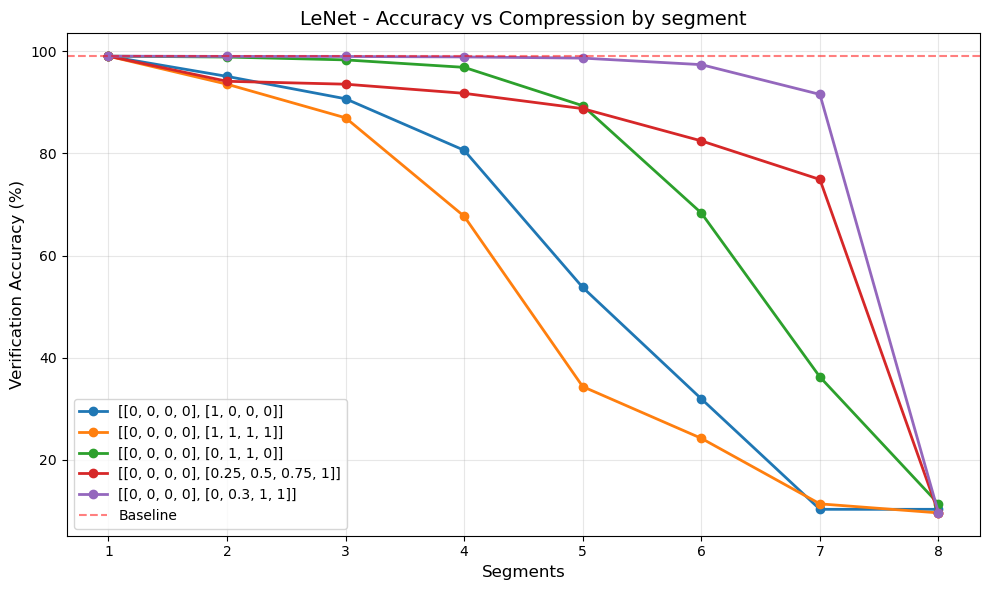

In [57]:
plot_experiment_results(checkpoint, results, model_name, max_segments)

@@@@@@@@@@@